## Dominican Urban Artists Spotify Analysis ##
This is a much improved version of a previous analysis I performed last year. As I've gotten more experienced with Python, I felt the need to remake it from scratch. The goal of this analysis is also of a much higher scope, as the previous version mostly dealt with trying to find the most popular artists. Here we'll try and see if we can explain why some artists are more popular than others, by processing their top tracks and finding their characteristics such as tempo, rhythm, danceability, etc.

First we'll start importing the libraries we need. We'll use the basic stuff like Pandas, Matplotlib, Requests, etc, but also a specialized library called **Spotipy** that adapts all the Spotify API endpoints and methods to Python.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests as rs
import spotipy as spo
import spotipy.util as util
import sys
import json
import numpy as np
from pandas.io.json import json_normalize
from sklearn.metrics import r2_score
%matplotlib inline

Spotify requires authorization in order th process all this. In theory, since I won't be accessing any users' info, I shouldn't need a token, but it seems the Spotipy library needs it. On top of that, while I should request access with no scope (since again, we won't be exploring any user), Spotipy can't handle no scope and returns an error the second time you try to refresh the token. Oh yeah, that's another limitation: Spotify only makes tokens valid for one hour. So yeah, refreshing is gonna be necessary pretty much every time we run this analysis.

In [3]:
# 
client_id = "c688c408926049ff9dc7617f43821c86"
client_secret = "41bfbf858b0c48ee96e50eec0cb67f48"
redirect_uri = "https://www.spotify.com"
scope='user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username") % (sys.argv[0],)
    sys.exit()
    
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
token

'BQCBF2GkjffuDVdRAU8Fth0x-2CQy_w6TpDhYq1tgIUedFfvlC4xr025MpfQEesoeFr7NaHBNQBbpduLUH4ozPMmGSJG6xCuQl7idJjSgykQz5qs14EtILx37Vs2bPVfilyreiXiFqPHJuzd0oa9Zxx8uYAh8cjV-g6id6DZDM0'

After we get the token, next step is creating a Spotify object, which will be the basis of all of our requests.

In [4]:
spot = spo.Spotify(auth=token)

We then proceed to create a list of the artists we want to extract and feed it tothe Spotify object with a search method. We'll pick the first result of each search, as 99% of the time, that willbe the artists we're looking for. We're also using the Dominican market, represented by the DO code.

In [5]:
artistas = ["El Alfa", "El Mayor", "Lapiz Conciente", "Amenazzy", "Vakero", "La Materialista", "Musicologo",
            "Shadow Blow", "La Insuperable", "Shelow Shaq", "Secreto", "Químico", "La Manta", "Black Jonas",
            "Mark B", "Chimbala", "Kikada", "Poeta Callejero", "Rochy", "Kiko El Crazy", "Don Miguelo",
           "Sensato", "Mozart La Para", "Lirico En La Casa", "Liro Shaq", "Super Nuevo", "Amara La Negra",
           "Bulova", "Crazy Design", "MelyMel", "Chuape", "Bulin 47", "Milka La Mas Dura", "Ceky Vicini", "Carlitos Way",
           "Manyao"]
artists_id = {}
for art in artistas:
    temp = spot.search(q="artist:" + art, type = "artist", market="DO")
    artists_id[art] = temp["artists"]["items"][0]

In [9]:
art

'Manyao'

In case we get an error, it will because no artist was found for that specific string. We'll check the **art** variable, as it will have the value that produced the error.

Here we check one of the artists' dictionary to identify the columns we want. In this case we'll choose **Name, Popularity and ID** since those seem to be the most relevant for our needs. Genres might be useful, but it's either not standardized across artists or will just complicate matters unneedlessly.

In [7]:
artists_id["El Alfa"]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2oQX8QiMXOyuqbcZEFsZfm'},
 'followers': {'href': None, 'total': 690372},
 'genres': ['dembow',
  'latin',
  'rap dominicano',
  'reggaeton',
  'reggaeton flow',
  'tropical'],
 'href': 'https://api.spotify.com/v1/artists/2oQX8QiMXOyuqbcZEFsZfm',
 'id': '2oQX8QiMXOyuqbcZEFsZfm',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/52603cddb5b4a4bde5c0dc011b07c6f5ad285909',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/62b392f174e84a8f0fccb87ea727438773b34d4f',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/716e74bb16dbc1a2cf68ac30c8a42a7678204c36',
   'width': 160}],
 'name': 'El Alfa',
 'popularity': 83,
 'type': 'artist',
 'uri': 'spotify:artist:2oQX8QiMXOyuqbcZEFsZfm'}

We then proceed to extract the keys we chose and put them in a list, then use that info to create a DataFrame. Pretty basic stuff.

In [8]:
artists_info = []
for key in artists_id:
    relevant = dict((k, artists_id[key][k]) for k in ['name', 'popularity', "id"] if k in artists_id[key])
    artists_info.append(list(relevant.values()))
artists_info

[['El Alfa', 83, '2oQX8QiMXOyuqbcZEFsZfm'],
 ['El Mayor Clasico', 53, '5sZ0LIk7BJLJquEUUt5rJj'],
 ['Lapiz Conciente', 57, '0UTsdD7VIsEB9i7a6DDx5t'],
 ['Amenazzy', 73, '6kq4GHwUcUojGIu0ziSNXf'],
 ['Vakero', 42, '5rlwbF5flU2JCmAzV5Obu0'],
 ['La Materialista', 46, '4FMqE1IWlhufYw1x2zlKG6'],
 ['Musicologo The Libro', 56, '0lIw3RIPiAC50dWNjJXe2Q'],
 ['Shadow Blow', 61, '53cVnpkm8dTmf20tssYSNF'],
 ['La Insuperable', 49, '1DnmGMN1A57wUR0KhxOnnu'],
 ['Shelow Shaq', 68, '658X86qMyJpSRY87oPvExU'],
 ['Secreto "El Famoso Biberon"', 56, '37UACiDcdzEYii0iU0QpAf'],
 ['Quimico Ultra Mega', 64, '3tZdknQnzsVIIdaGCTj4RX'],
 ['La Manta', 51, '3omyT5zHz9QmE63xEk10OV'],
 ['Black Jonas Point', 47, '5ImkeVBlU11axX5QwOWg12'],
 ['Mark B.', 64, '0zZJhc1T0zBurhnBwQ2fcu'],
 ['Chimbala', 70, '4VVEpEhC8NcR7AqNEds42U'],
 ['La Kikada', 49, '7Fpb4yEAPfiQfY0Bx0uLm5'],
 ['Poeta Callejero', 47, '1m82A2YUjBaQnLAFi9vjJv'],
 ['Rochy RD', 56, '4riOEaOW5hCeqomFDBk0aP'],
 ['Kiko el Crazy', 56, '3NpG6SsHaQETkdQVZH6V1E'],
 ['Don 

In [11]:
urbanos = pd.DataFrame(artists_info, columns=["name", "popularity", "artist_id"])

In [12]:
urbanos

,name,popularity,artist_id
0,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm
1,El Mayor Clasico,53,5sZ0LIk7BJLJquEUUt5rJj
2,Lapiz Conciente,57,0UTsdD7VIsEB9i7a6DDx5t
3,Amenazzy,73,6kq4GHwUcUojGIu0ziSNXf
4,Vakero,42,5rlwbF5flU2JCmAzV5Obu0
5,La Materialista,46,4FMqE1IWlhufYw1x2zlKG6
6,Musicologo The Libro,56,0lIw3RIPiAC50dWNjJXe2Q
7,Shadow Blow,61,53cVnpkm8dTmf20tssYSNF
8,La Insuperable,49,1DnmGMN1A57wUR0KhxOnnu
9,Shelow Shaq,68,658X86qMyJpSRY87oPvExU


In [13]:
urbanos.iloc[0:5]["artist_id"]

0    2oQX8QiMXOyuqbcZEFsZfm
1    5sZ0LIk7BJLJquEUUt5rJj
2    0UTsdD7VIsEB9i7a6DDx5t
3    6kq4GHwUcUojGIu0ziSNXf
4    5rlwbF5flU2JCmAzV5Obu0
Name: artist_id, dtype: object

We then proceed to pass the artists ID and get the different categories to select the ones we want. From this source, we want Name, Popularity and Duration.

In [14]:
top_dicts = []
top_artists = []
for number in urbanos["artist_id"]:
    temp = spot.artist_top_tracks(number)
    top_dicts.append(temp)


In [15]:
top_dicts[0]["tracks"][1].keys()

dict_keys(['album', 'artists', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'is_playable', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [16]:
track_keys = ["name", "popularity", "duration_ms", "id"]

Then we get the top tracks for each artists. At 5 track per artist, we'll get a nice chunk of data.

In [17]:
top_tracks = []
artists_pos = 0

for a in range(len(top_dicts)):
    temp1 = top_dicts[a]["tracks"]
    for b in range(len(temp1)):
        temp2 = dict((k, temp1[b][k]) for k in track_keys if k in temp1[b])
        temp2 = list(temp2.values())
        temp2.insert(0, urbanos["artist_id"][a])
        temp2.insert(0, urbanos["popularity"][a])                    
        temp2.insert(0, urbanos["name"][a])
        top_tracks.append(temp2)
#         top_tracks[b].insert(0,urbanos["name"][a])
#     artists_pos+=1

#     dict((k, top_alfa["tracks"][0][k]) for k in track_keys if k in top_alfa["tracks"][0])

Then from those songs we extract Song Popularity, Duration and match it with each artist's info.

In [18]:
top_tracks_urbanas = pd.DataFrame(top_tracks, columns=["artist", "artist_pop", "artist_id", "song", "song_pop", "song_duration_ms", "song_id"])

Now we're going to get advantage of Spotify's ready made analysis results in the form of song features. These will provide us really meaty information for our upcoming analysis.

In [19]:
song_features = []
for song in top_tracks_urbanas["song_id"]:
    song_features.append(spot.audio_features(song))


In [20]:
feature_columns = song_features[0][0].keys()

In [21]:
features_list = []
for a in range(len(song_features)):
    features_list.append(list(song_features[a][0].values()))

In [22]:
top_track_features = pd.DataFrame(features_list, columns=feature_columns)

We now save tracks and track features into CSVs so we don't have to call the API anymore.

In [23]:
top_tracks_urbanas.to_csv(r".\top_track_urbanas.csv")

In [24]:
top_track_features.to_csv(r".\top_track_features.csv")

In [25]:
top_track_features = pd.read_csv("top_track_features.csv")
top_tracks_urbanas = pd.read_csv("top_track_urbanas.csv")


In [26]:
top_urbanas = pd.concat([top_tracks_urbanas,top_track_features], axis=1)

In [27]:
top_urbanas = top_urbanas.drop(["id", "type", "song_duration_ms", "track_href", "uri", "analysis_url", "Unnamed: 0"], axis=1)

In [28]:
top_urbanas.to_csv(r".\top_urbanas.csv")

In [29]:
top_urbanas = pd.read_csv("top_urbanas.csv", index_col=0)

After concatenating the previous dataframes and selecting the appropriate columns, we now have a nice list of the each artist and their top 5 songs, and each song features.

In [30]:
top_urbanas.head()

,artist,artist_pop,artist_id,song,song_pop,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm,Que Calor (feat. J Balvin & El Alfa),78,1RKZvaLj3UPhGjZkaIrFm7,0.795,0.885,8,-4.130,1,0.0713,0.0375,0.006380,0.2920,0.460,126.037,169998,4
1,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm,Coronao Now,80,7FbKipScVxkjQxQXwTd0gL,0.941,0.729,6,-7.560,0,0.2460,0.1460,0.004510,0.1800,0.718,118.026,217881,4
2,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm,La Romana,79,1khmgu0pveJbkbpbkyvcQv,0.655,0.725,0,-5.497,1,0.1880,0.0327,0.002640,0.0611,0.326,125.800,300579,4
3,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm,badwine - Extended Remix,68,44DCGBt8P6iZPd0RRsZiMw,0.766,0.763,1,-5.702,1,0.2050,0.3760,0.000176,0.1000,0.732,186.004,248160,4
4,El Alfa,83,2oQX8QiMXOyuqbcZEFsZfm,Dembow y Reggaeton,65,0BvhrGwe5MtFFf9gMIeWbp,0.898,0.890,5,-2.155,1,0.0599,0.3800,0.062200,0.1710,0.672,117.064,249744,4


In [31]:
# Here we'll create a colormap based on the artists for categorical colorization
tags = {}
for a in range(len(artistas)):
    tags[top_urbanas["artist"].unique()[a]] = a
artist_map = [tags[a] for a in top_urbanas["artist"]]

We'll now look at the different visualizations to see which patterns can we find.

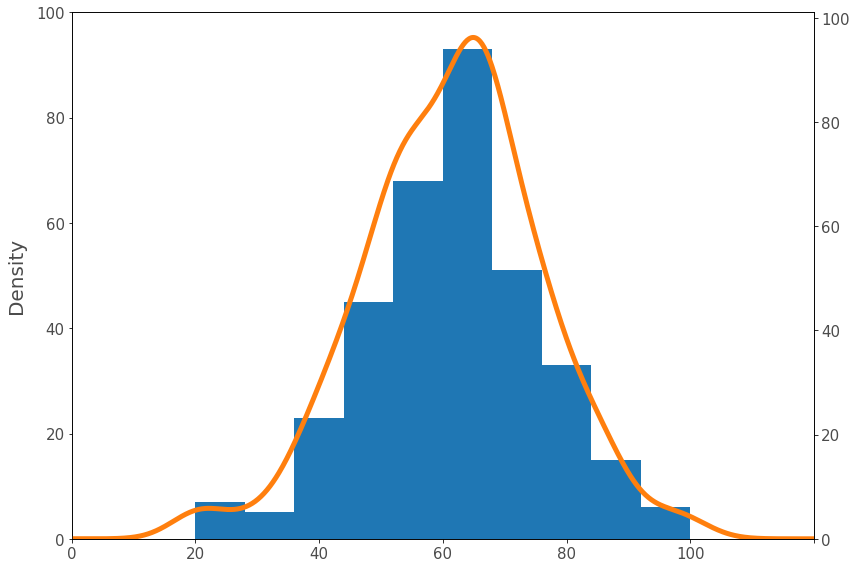

In [32]:
y = top_urbanas["artist"]
x = top_urbanas["song_pop"]
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.hist(x=x, bins=10)
ax.set_yticks(range(0,120,20))
ax.set_yticklabels(range(0,120,20), alpha=0.7, size=15)
ax.set_xticklabels(range(0,120,20), alpha=0.7, size=15)
ax.set_ylabel("Desnsity", alpha=0.7, size=20, labelpad=10)
ax2 = x.plot.kde(ax=ax, secondary_y=True, linewidth=5)
ax2.set_yticks([x/1000 for x in range(0,36,6)])
ax2.set_yticklabels(range(0,120,20), alpha=0.7, size=15)


ax2.set_ylim(0)
ax2.set_xlim(-20,100)
fig.tight_layout()

The popularity of dembow songs ranges from 0-80, with around 30% oscilating around the 60 points mark.

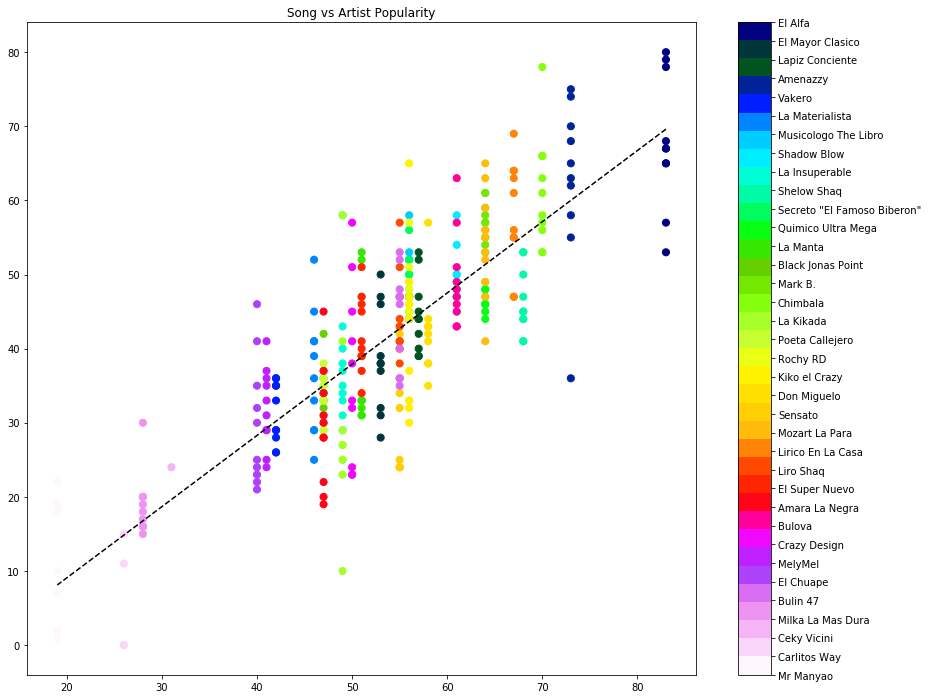

In [33]:
x = top_urbanas["artist_pop"]
y = top_urbanas["song_pop"]

plt.figure(figsize=(15,12))

plt.scatter(x, y, s=50, c=artist_map, cmap=plt.cm.get_cmap('gist_ncar', 36))
formatter = plt.FuncFormatter(lambda val, loc: list(tags.keys())[val])
plt.colorbar(ticks=list(tags.values()), format=formatter).ax.invert_yaxis()
plt.title("Song vs Artist Popularity")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")

plt.show()

As expected, there's a direct correlation between an artist popularity and the popularity of the songs they produce. Although said effect diminishes a bit as artist popularity grows. Seems there's only so much it can help the material beyond he song's performance. If we look closer, we'll notice two facts:

- It's uncommon that a song gets to be more popular than the artist that produced it.
- Artists have a range of around 15-30 points spread for the popularity of their songs, it's extremely rare that a song gets outside that range for any artist.

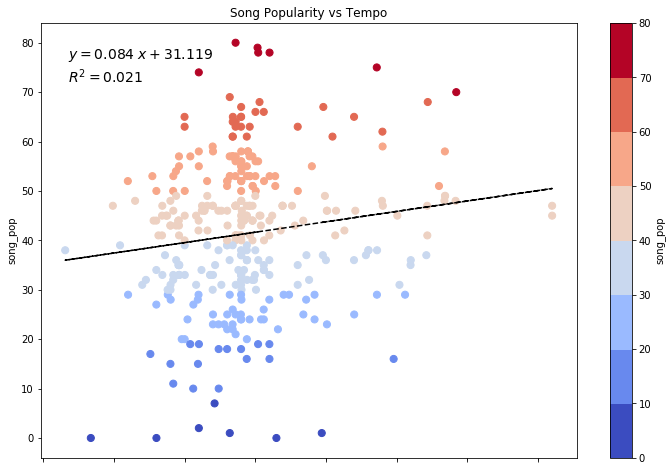

In [34]:
x = top_urbanas["tempo"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="tempo", y="song_pop", c="song_pop", s=50,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Tempo", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Tempo seems to have a slight impact on popularity, alluding to the fact dembow is a fast-paced genre, so it makes sense that having a faster pace is rewarded with success.

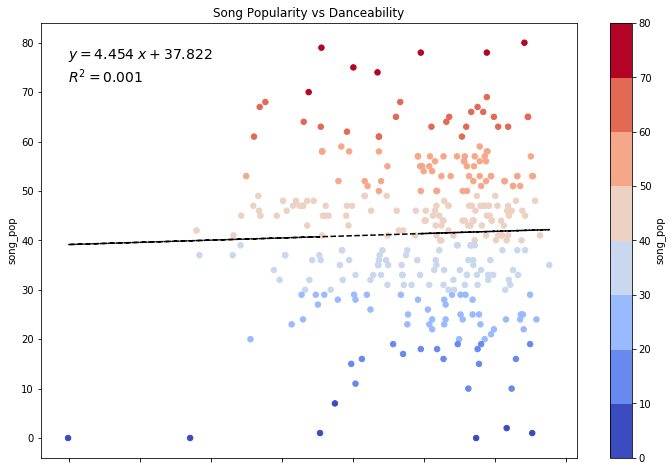

In [35]:
x = top_urbanas["danceability"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="danceability", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Danceability", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

So-called danceability has little effect on the popularity of songs, which is weird given it's a very danceable rhythm. Maybe the Spotify analyses aren't adjusted for dembow.

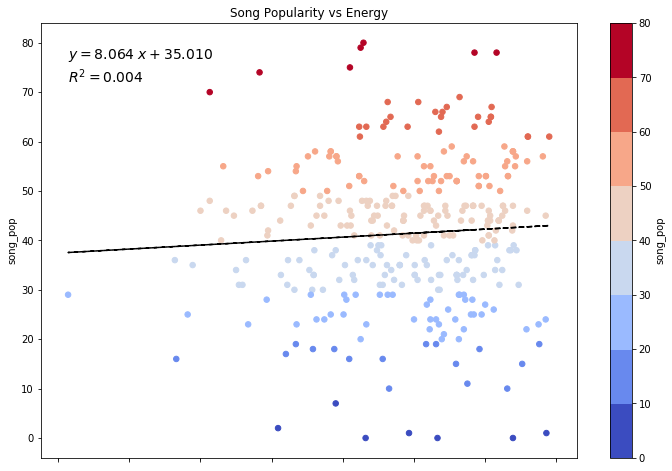

In [69]:
x = top_urbanas["energy"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="energy", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Energy", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Likewise, the so-called energy, seems to have little effect on popularity.

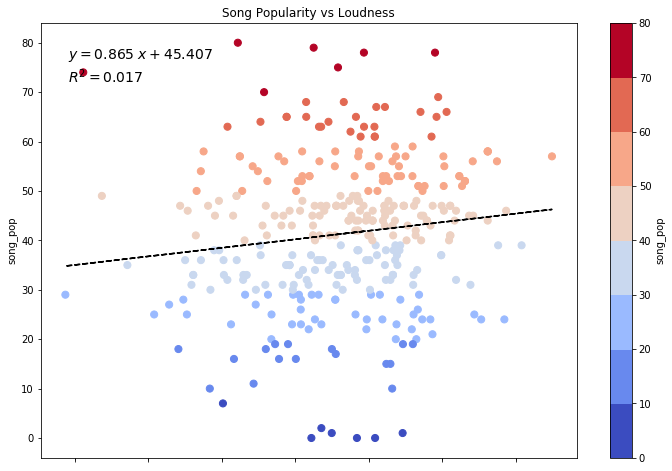

In [37]:
x = top_urbanas["loudness"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="loudness", y="song_pop", c="song_pop", s=50,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Loudness", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Loudness does seem to have an effect on popularity, which makes sense since dembow is usually enjoyed at very loud volumes in parties, houseparties and tailgate parties.

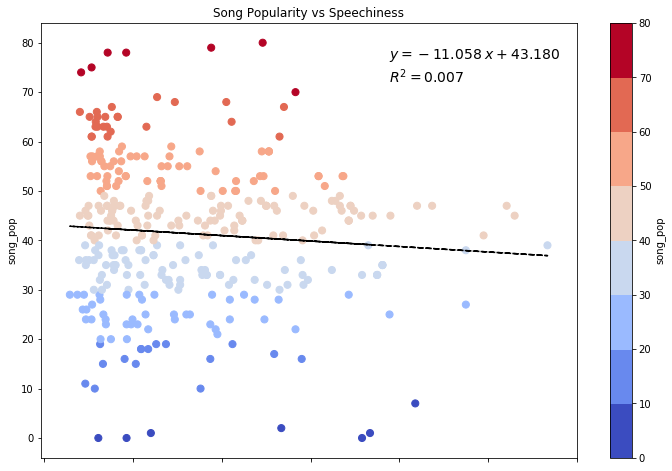

In [38]:
x = top_urbanas["speechiness"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="speechiness", y="song_pop", c="song_pop", s=50,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Speechiness", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.65, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

This one is pretty funny, because dembow it's known for having little lyrics and focusing on repetitive phrases sychronized to the slapping music. So the fact there's *indeed* a negative correlation between amount of speech and popularity is quite hilarious.

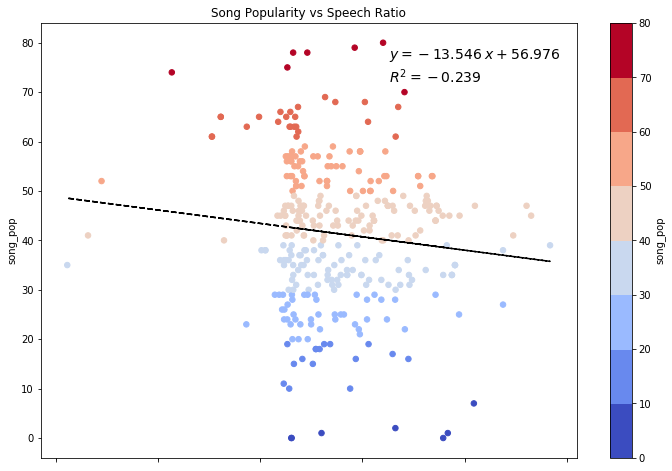

In [67]:
top_urbanas["speech_ratio"] = (top_urbanas["speechiness"]+1) / (top_urbanas["instrumentalness"]+1)
x = top_urbanas["speech_ratio"]
y = top_urbanas["song_pop"]
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="speech_ratio", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Speech Ratio", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.65, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Oh, now this is surprising, although not unexpected. There's a very high correlation between how instrumental a song is, and how popular it is. Which relates to the previous graphic and drives the point home even harder: If you want your dembow to be successful, sing the least as possible, as dembow **is not** a heavy lyric genre.

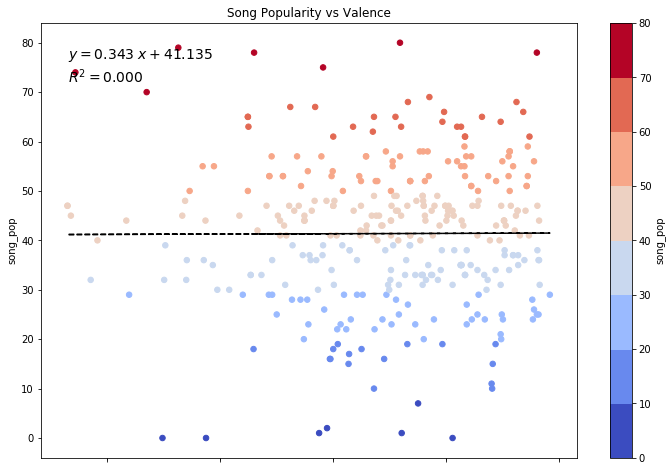

In [45]:
x = top_urbanas["valence"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="valence", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Valence", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

As with danceability, there seems to be an issue with valence. Doesn't seem to work for dembow, as most dembow is happy, but maybe being an angry genre is affecting the score and cancelling out the happiness.

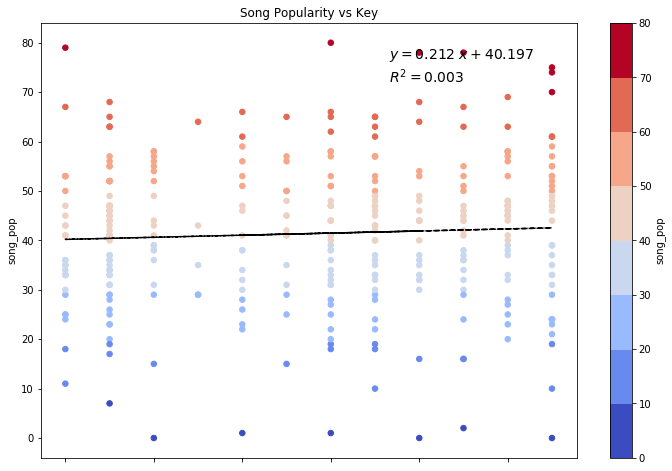

In [46]:
x = top_urbanas["key"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="key", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Key", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.65, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Key doesn't seem to really affect song popularity.

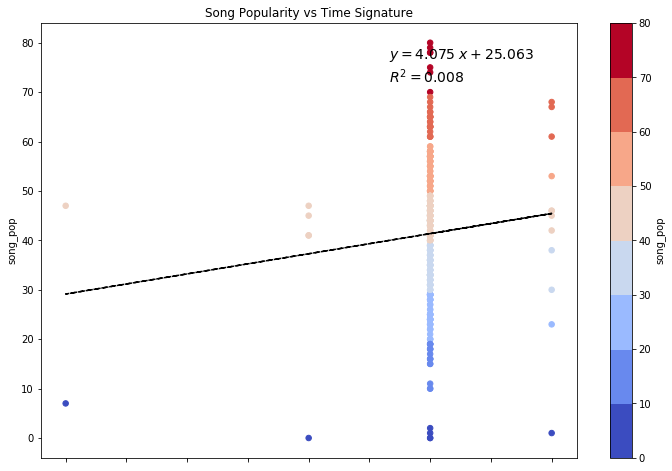

In [47]:
x = top_urbanas["time_signature"]
y = top_urbanas["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = top_urbanas.plot(kind="scatter", x="time_signature", y="song_pop", c="song_pop", s=30,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Song Popularity vs Time Signature", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.65, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Time signature does have a considerable influence on the popularity of a song, with higher signatures representing a faster-paced tempo, which we already know plays a big part on a song's success.

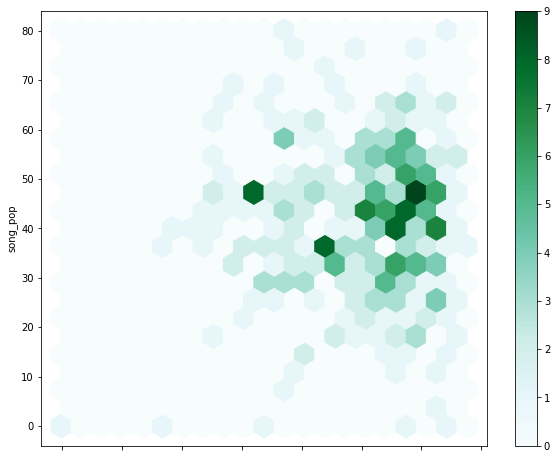

In [48]:
x = "danceability"
y = "song_pop"
top_urbanas.plot(kind="hexbin", x=x, y="song_pop", gridsize=20, figsize=(10,8))


In [49]:
top_urbanas.describe(include="all")

,artist,artist_pop,artist_id,song,song_pop,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,speech_ratio
count,346,346.000000,346,346,346.000000,346,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,3.460000e+02
unique,36,NaN,36,314,NaN,315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,El Super Nuevo,NaN,5sZ0LIk7BJLJquEUUt5rJj,En Filita Cooperando - Remix,NaN,41ezMG36bvrbJaJpvlbDFf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,NaN,10,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,53.615607,NaN,NaN,41.375723,NaN,0.797798,0.789405,5.554913,-4.657861,0.595376,0.163216,0.189895,0.013657,0.214627,0.700309,121.753185,215748.046243,4.002890,6.583357e+05
std,NaN,12.523355,NaN,NaN,14.392747,NaN,0.113085,0.116666,3.750732,2.190135,0.491530,0.107711,0.168184,0.070537,0.188108,0.181017,24.739777,66381.561746,0.318498,1.172898e+06
min,NaN,19.000000,NaN,NaN,0.000000,NaN,0.298000,0.314000,0.000000,-12.251000,0.000000,0.028700,0.000003,0.000000,0.028600,0.130000,57.753000,105693.000000,1.000000,1.065665e-01
25%,NaN,47.000000,NaN,NaN,32.250000,NaN,0.724250,0.714500,1.000000,-6.024750,0.000000,0.074325,0.053425,0.000000,0.077800,0.590250,106.110750,182668.000000,4.000000,1.427257e+02
50%,NaN,55.000000,NaN,NaN,43.000000,NaN,0.827000,0.808500,6.000000,-4.347000,1.000000,0.127000,0.136000,0.000022,0.130500,0.720500,119.969500,201378.000000,4.000000,6.648900e+03
75%,NaN,61.000000,NaN,NaN,50.000000,NaN,0.882750,0.882750,9.000000,-3.216750,1.000000,0.229250,0.288000,0.000643,0.305750,0.835750,127.735250,230021.750000,4.000000,7.942510e+05


In [50]:
mean_urbanos = top_urbanas.groupby("artist").agg(np.mean)

In [51]:
mean_urbanos

,artist_pop,song_pop,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,speech_ratio
artist,,,,,,,,,,,,,,,,
Amara La Negra,47.0,29.4,0.7276,0.8125,5.2,-5.1857,0.2,0.15117,0.170100,0.000943,0.19628,0.6531,127.3143,209436.2,4.0,5.533023e+05
Amenazzy,73.0,62.6,0.6940,0.7125,6.6,-5.8495,0.6,0.09543,0.290260,0.025981,0.14126,0.5585,136.5577,226099.9,4.1,2.513343e+05
Black Jonas Point,47.0,34.2,0.7563,0.7242,7.4,-5.4972,0.4,0.16691,0.302870,0.001093,0.20994,0.6163,110.4469,197332.5,4.0,1.423844e+06
Bulin 47,55.0,44.0,0.8937,0.7622,5.6,-3.5294,0.8,0.19549,0.100622,0.000156,0.28562,0.7159,114.8798,187317.6,4.0,4.688595e+05
Bulova,61.0,49.2,0.8527,0.8073,4.4,-4.4946,0.9,0.11682,0.174877,0.012257,0.20063,0.7463,120.1960,200157.4,4.0,4.416136e+05
Carlitos Way,26.0,5.2,0.6082,0.8662,5.2,-4.8712,1.0,0.12470,0.178693,0.005841,0.16714,0.5982,96.0580,165995.2,3.8,9.730161e+05
Ceky Vicini,31.0,24.0,0.9350,0.8000,7.0,-0.9400,1.0,0.24800,0.071900,0.000007,0.06360,0.6310,120.0200,198000.0,4.0,3.517732e+04
Chimbala,70.0,61.1,0.8385,0.8530,5.3,-3.5754,0.8,0.09375,0.317680,0.001230,0.13189,0.8062,127.8615,188544.2,4.1,4.424541e+05
Crazy Design,50.0,36.7,0.7880,0.7554,6.9,-4.9326,0.5,0.12530,0.091594,0.017566,0.32411,0.7540,123.0703,203546.9,4.1,4.070307e+05


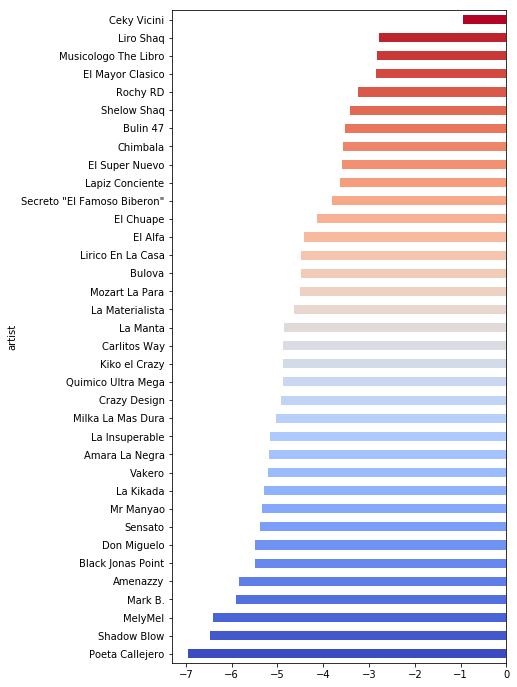

In [78]:
cmap = plt.cm.coolwarm(np.linspace(0,1,36))
mean_urbanos["loudness"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)



Even though when looking at popularity by song we found that *danceability* has little effect and doubted the Spotify algorythms, when we look by artist, we do kind of see that it kinda matches with reality as Ceky, Bulin, Chuape and others feature very catchy songs that make you bob unintentionally.

In [ ]:
tempo = top_urbanas.sort_values(by="tempo", ascending=False).head(10).reset_index(drop=True)
tempo.index = tempo.index+1

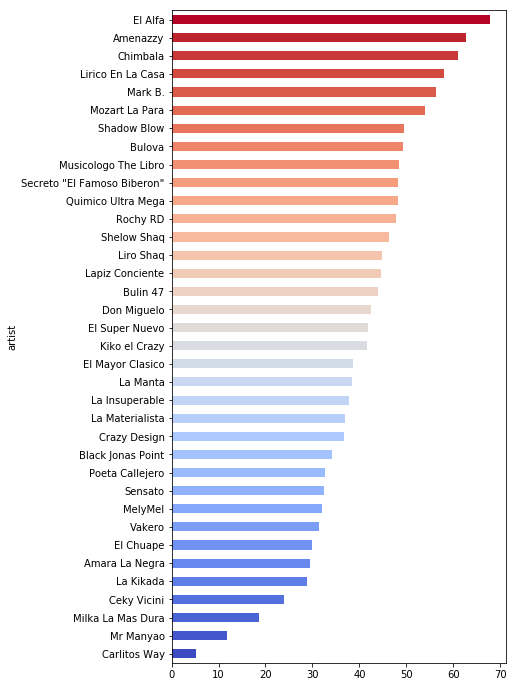

In [60]:
cmap = plt.cm.coolwarm(np.linspace(0,1,36))
mean_urbanos["song_pop"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)

The high majority of featured dominican urban artists fall on a song popularity between 28-48, then we have the clear outliers on the bottom side, such as **Ceky, Milka, Manyao and Carlitos Way**, and the outliers on the top side, such as **Mozart, Mark B, Lirico, Chimbala, Amenazzy and Alfa**.

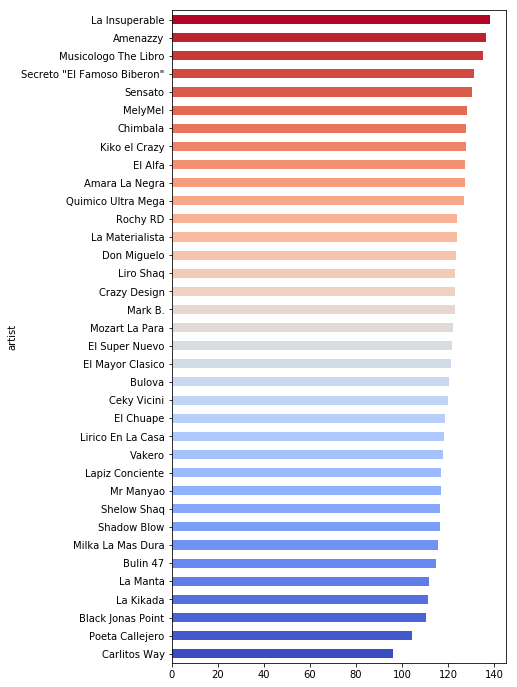

In [70]:
cmap = plt.cm.coolwarm(np.linspace(0,1,36))
mean_urbanos["tempo"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)


If we look at artists by the *energy* parameter, then **Mayor, Lírico, Carlitos, Liro Shaq and Musicologo** are the most energetic artists of our list.

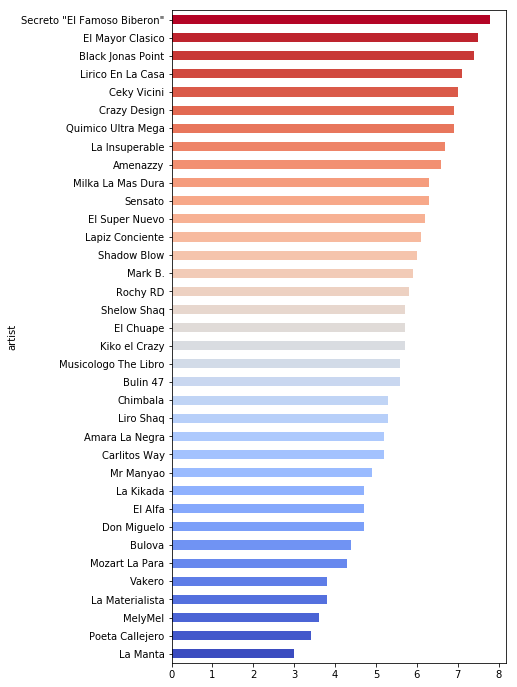

In [76]:
cmap = plt.cm.coolwarm(np.linspace(0,1,36))
mean_urbanos["key"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)

In terms of the *key* used in their song's composition, we see that artists like **Secreto, Mayor, Black Jonas, Lirico and Ceky** feature a higher average key higher than 7, while artists like **La Manda, Poeta, MelyMel, MAterialista and Vakero** feature a lower average key, lower than 4. Given the evident difference in success between the two groups, it does indeed seems that having a higher key results in having a more successful output. Remember that when we looked at the key parameter on a per song basis, we saw no evidence of effect on the success of a song. Let's look at a scatter plot of avg key and avg song pop on a per artist level.

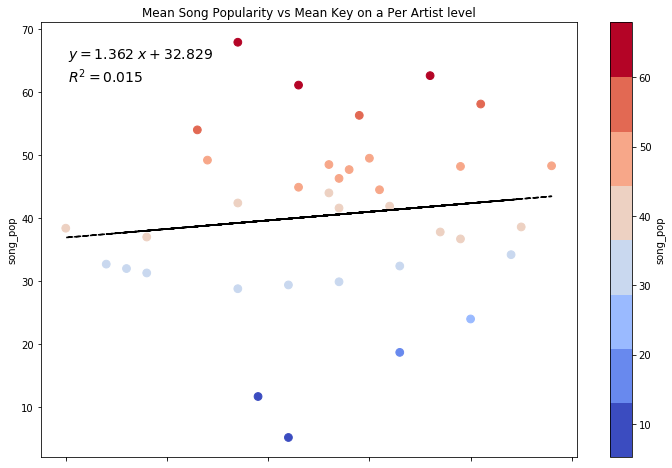

In [77]:
x = mean_urbanos["key"]
y = mean_urbanos["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = mean_urbanos.plot(kind="scatter", x="key", y="song_pop", c="song_pop", s=60,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Mean Song Popularity vs Mean Key on a Per Artist level", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

While artists such as El Alfa and Chimbala are among the ones with the most popular songs, yet their key height is average or below average, there's a clear link between having popular songs and using a higher key.

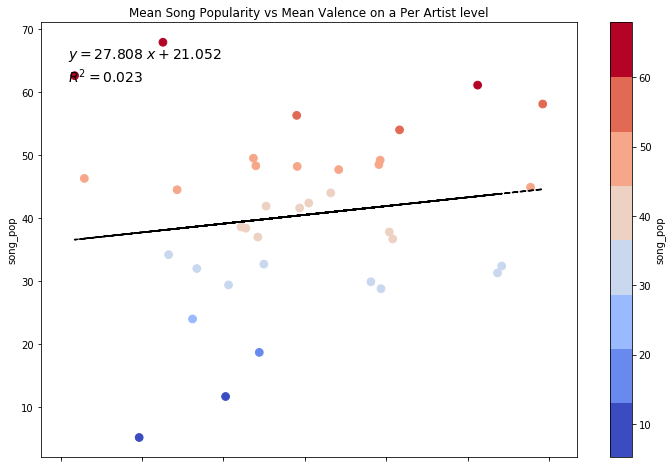

In [65]:
x = mean_urbanos["valence"]
y = mean_urbanos["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = mean_urbanos.plot(kind="scatter", x="valence", y="song_pop", c="song_pop", s=60,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Mean Song Popularity vs Mean Valence on a Per Artist level", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

With the valence parameter we keep confirming aspects that appear seemingly meaningless on a per song level, end up being relevant on a per artist level. Although interestingly, the two top artsts are on the bottom of the valence scale. On the other hand, since they're outliers and the correlation is *still* evident, we can conclude that the correlation is even stronger.

Now we wonder, if meaningless per song parameters increase their importance if we look at them on a per artist basis, what would happen to parameters which are already important? Let's find out by using the most relevant per song parameters: **Tempo and Loudness**

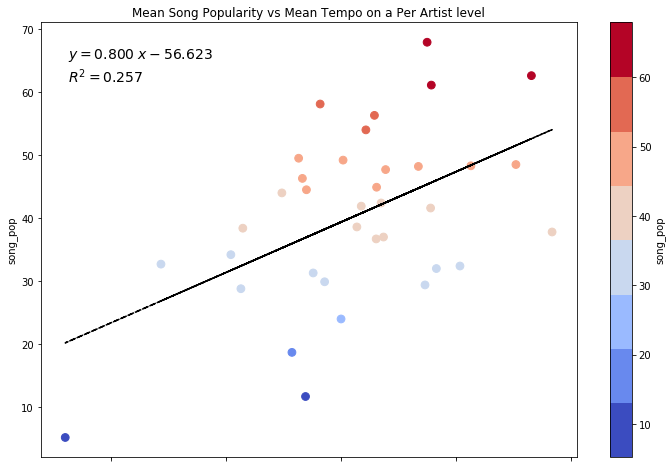

In [63]:
x = mean_urbanos["tempo"]
y = mean_urbanos["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = mean_urbanos.plot(kind="scatter", x="tempo", y="song_pop", c="song_pop", s=60,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Mean Song Popularity vs Mean Tempo on a Per Artist level", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Wooooooow. The importance of tempo skyrocketed. It's very, very clear now that tempo has a huge effect on popularity. Let's look at Loudness.

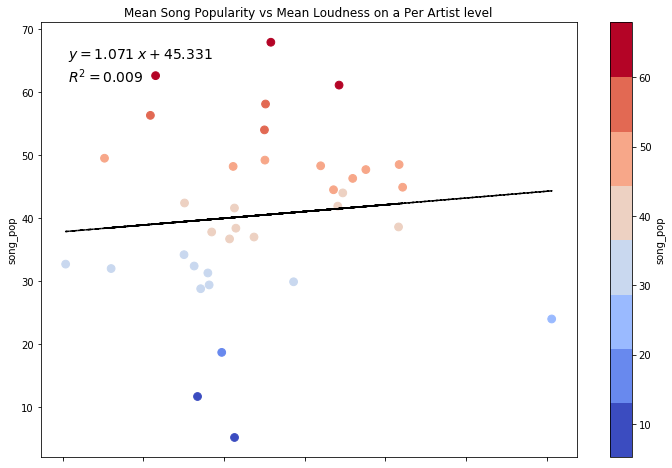

In [64]:
x = mean_urbanos["loudness"]
y = mean_urbanos["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = mean_urbanos.plot(kind="scatter", x="loudness", y="song_pop", c="song_pop", s=60,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Mean Song Popularity vs Mean Loudness on a Per Artist level", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Mmm, seems that Tempo basically remained the same. It actually decreased 50% on a nominal level, but overall, the slope barely changed.

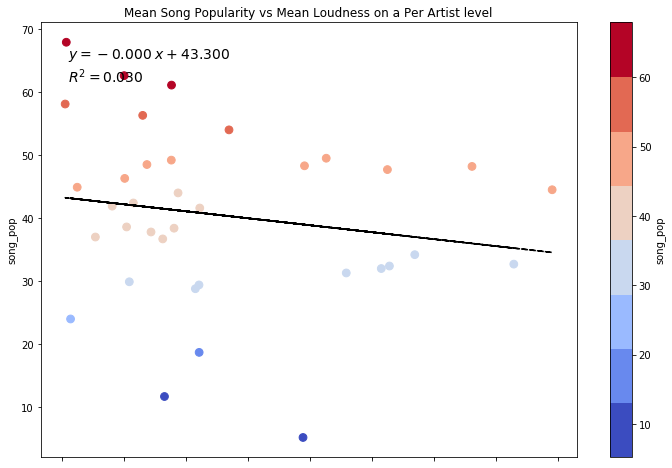

In [68]:
x = mean_urbanos["speech_ratio"]
y = mean_urbanos["song_pop"]
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
ax = mean_urbanos.plot(kind="scatter", x="speech_ratio", y="song_pop", c="song_pop", s=60,
                 colormap=plt.cm.get_cmap('coolwarm',8),
                 title="Mean Song Popularity vs Mean Speech Ratio on a Per Artist level", figsize = (12,8), legend=True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

Speech ratio nominal level decreased, but the slope is similar like the one on a per song basis.

### Conclusion ###

After reviewing more than 300 songs from dominican urban artitsts, and considering contexts such as each artist individual popularity, we can conclude that in order to have popular songs, the most important aspects to consider when producing a song are: **Tempo, Amount of Speech, Loudness and the Key used for the composition**.

Tempo: Fast-paced rhythms is the name of the game in urban music. Try to have tempos above 120 BPM.
Amount of Speech: Don't talk too much, let the music do the job. This doesn't diminish the importance of the rapper/singer, but does prove the producer is at least as equally important, if not more.
Loudness: Seems that anything above -5 dB is game.
Key: High-key music tends to produce better results, so anything above 5/Fa and mostly on a major key, will yield good results.

So the parameters to have an urban dominican hit song will be **120 BPM, on 5/Fa Major, sound above -4dB and don't have a lot of lyrics**